<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_29_seq2seq(train).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""7-2.seq2seq(train).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1JTAi6RAcWra699bbk14qUiF-oihva5qZ
"""

# Commented out IPython magic to ensure Python compatibility.
# 작업 디렉토리를 변경한다.
# %cd '/content/drive/My Drive/Colab Notebooks'

# Seq2Seq 모델를 이용한 ChatBot : 학습 모듈 (Teacher forcing)
#
# 관련 논문 : Kyunghyun Cho, et. al., 2014,
#             Learning Phrase Representations using RNN Encoder–Decoder 
#             for Statistical Machine Translation
#
# 저작자: 2021.05.26, 조성현 (blog.naver.com/chunjein)
# copyright: SNS 등에 공개할 때는 출처에 저작자를 명시해 주시기 바랍니다.
# ----------------------------------------------------------------------
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle


In [ ]:
# Sub-word 사전 읽어온다.
with open('/content/drive/MyDrive/머신러닝/seq2seq/chatbot_voc.pkl', 'rb') as f:
    word2idx,  idx2word = pickle.load(f)

# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 읽어온다.
with open('/content/drive/MyDrive/머신러닝/seq2seq/chatbot_train.pkl', 'rb') as f:
    trainXE, trainXD, trainYD = pickle.load(f)

In [ ]:
VOCAB_SIZE = len(idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = '/content/drive/MyDrive/머신러닝/seq2seq/chatbot_trained.h5'
LOAD_MODEL = True

In [ ]:
 trainXD[0]

array([  2, 259,   6, 100,  89,  36,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [ ]:
[idx2word[i] for i in trainXD[0]]

['<BOS>',
 '▁하루',
 '가',
 '▁또',
 '▁가',
 '네요',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [ ]:
# 워드 임베딩 레이어. Encoder와 decoder에서 공동으로 사용한다.
K.clear_session()
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)
# vocab_size : len(word2idx)

# Encoder
# -------
# many-to-one으로 구성한다. 중간 출력은 필요 없고 decoder로 전달할 h와 c만
# 필요하다. h와 c를 얻기 위해 return_state = True를 설정한다.
encoderX = Input(batch_shape=(None, trainXE.shape[1]))
encEMB = wordEmbedding(encoderX)
encLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True) # 1층에서 2층으로 보내기 위해 retrun_sequence 필요
# retrun_state : h, c 출력 
encLSTM2 = LSTM(LSTM_HIDDEN, return_state = True)
ey1, eh1, ec1 = encLSTM1(encEMB)    # LSTM 1층 
_, eh2, ec2 = encLSTM2(ey1)       # LSTM 2층

# Decoder
# -------
# many-to-many로 구성한다. target을 학습하기 위해서는 중간 출력이 필요하다.
# 그리고 초기 h와 c는 encoder에서 출력한 값을 사용한다 (initial_state)
# 최종 출력은 vocabulary의 인덱스인 one-hot 인코더이다.
decoderX = Input(batch_shape=(None, trainXD.shape[1]))
decEMB = wordEmbedding(decoderX)
decLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
decLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = decLSTM1(decEMB, initial_state = [eh1, ec1]) # eh1, ec1 : Context vector
dy2, _, _ = decLSTM2(dy1, initial_state = [eh2, ec2]) 
decOutput = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
outputY = decOutput(dy2)

# Model
# -----
model = Model([encoderX, decoderX], outputY)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 128)      1152000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 15, 128), (N 131584      embedding[0][0]              

In [ ]:
if LOAD_MODEL:
    model.load_weights(MODEL_PATH)

In [ ]:
# 학습 (teacher forcing)
# ----------------------
hist = model.fit([trainXE, trainXD], trainYD, batch_size = 512, epochs=100, shuffle=True)

Epoch 1/100
24/24 [==============================] - 6s 43ms/step - loss: 2.0634
Epoch 2/100
24/24 [==============================] - 1s 42ms/step - loss: 2.0372
Epoch 3/100
24/24 [==============================] - 1s 42ms/step - loss: 2.0238
Epoch 4/100
24/24 [==============================] - 1s 42ms/step - loss: 2.0143
Epoch 5/100
24/24 [==============================] - 1s 41ms/step - loss: 2.0061
Epoch 6/100
24/24 [==============================] - 1s 41ms/step - loss: 1.9984
Epoch 7/100
24/24 [==============================] - 1s 41ms/step - loss: 1.9920
Epoch 8/100
24/24 [==============================] - 1s 41ms/step - loss: 1.9859
Epoch 9/100
24/24 [==============================] - 1s 40ms/step - loss: 1.9783
Epoch 10/100
24/24 [==============================] - 1s 40ms/step - loss: 1.9712
Epoch 11/100
24/24 [==============================] - 1s 41ms/step - loss: 1.9634
Epoch 12/100
24/24 [==============================] - 1s 41ms/step - loss: 1.9559
Epoch 13/100
24/24 [=====

In [ ]:
# 학습 결과를 저장한다
model.save_weights(MODEL_PATH)

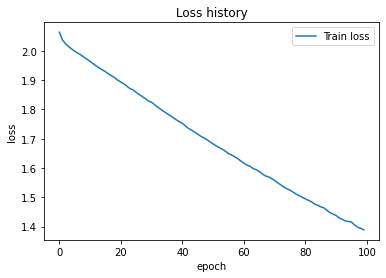

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()